## Import Library

In [1]:
import torch
from torch import nn 
import torchvision 
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm
import matplotlib.ticker as mticker
import pandas as pd 
import seaborn as sns 
sns.set()
 


##### Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

##### Here's an example of how the data looks (each class takes three-rows):

### Import Datasets

In [2]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True, 
    transform=ToTensor(), 
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True, 
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [3]:
X_train, y_train = train_data.data, train_data.targets
X_test, y_test = test_data.data, test_data.targets

In [4]:
random = torch.randint(len(X_train), (9,))

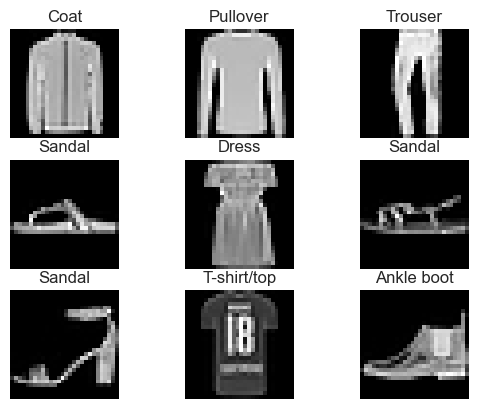

In [5]:

for i, x in enumerate(random):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[x], cmap='gray')
    plt.title(train_data.classes[y_train[x]])
    plt.axis('off')


In [6]:
y_train

tensor([9, 0, 0,  ..., 3, 0, 5])

c:\Users\yaqoo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'T-shirt/top'),
  Text(1, 0, 'Trouser'),
  Text(2, 0, 'Pullover'),
  Text(3, 0, 'Dress'),
  Text(4, 0, 'Coat'),
  Text(5, 0, 'Sandal'),
  Text(6, 0, 'Shirt'),
  Text(7, 0, 'Sneaker'),
  Text(8, 0, 'Bag'),
  Text(9, 0, 'Ankle boot')])

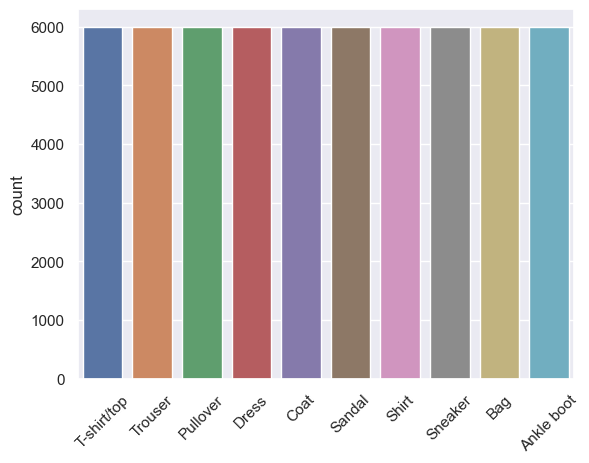

In [7]:
import seaborn as sns 
g = sns.countplot(y_train.tolist())
g.set_xticklabels(train_data.classes, ha='center')
plt.xticks(rotation=45)

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_data, 
    batch_size=32,
    shuffle=True, 
    num_workers=5
)

test_dataloader = DataLoader(test_data, 
batch_size=32,
shuffle=False,
num_workers=5)

train_dataloader, test_dataloader

train_features, trainlabels = next(iter(train_dataloader))



In [9]:

def train_model(model:nn.Module, epochs:int, optimizer:torch.optim, loss_fn, training_data, test_data, performance_dictionary=None):
    
    for epoch in tqdm(range(epochs)):

        train_count = 0
        train_len = 0 
        test_count = 0
        test_len = 0

        for batch, (X, y) in tqdm(enumerate(training_data)):
            model.train()
            y_train_logits = model(X)
            y_train_pred = torch.argmax(torch.softmax(y_train_logits, dim=1),1)
            loss = loss_fn( y_train_logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_count += torch.eq(y_train_pred, y).sum().item()
            train_len += len(y)
        train_acc = train_count/train_len

        model.eval()
        with torch.inference_mode():
            for batch, (X, y) in enumerate(test_data):
                y_test_logits = model(X)
                y_test_pred = torch.argmax(torch.softmax(y_test_logits, dim=1),1)
                test_count += torch.eq(y_test_pred, y).sum().item()
                test_len += len(y)
        test_acc = test_count/test_len
        if performance_dictionary is not None:
            performance_dictionary['train_loss'].append(loss.item())
            performance_dictionary['train_acc'].append(train_acc)
            performance_dictionary['test_acc'].append(test_acc)

        print(epoch + 1, '/', epochs,'' ,'Training Accuracy:', round(train_acc,2), '| Training loss:', round(loss.item(),2), '| Testing Accuracy:', round(test_acc,2) )

def plot_performance(performance_dictionary):
    pd.DataFrame(performance_dictionary).plot()
    plt.xlabel('epochs')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title('Model Performance Per Epochs')

def test_accuracy(model:nn.Module, test_dataloader):
    with torch.inference_mode():
        test_count = 0
        test_len = 0
        for batch, (X, y) in enumerate(test_dataloader):
            y_test_logits = model_2(X)
            y_test_pred = torch.argmax(torch.softmax(y_test_logits, dim=1),1)
            test_count += torch.eq(y_test_pred, y).sum().item()
            test_len += len(y)
    return test_count/test_len

def predict(model:nn.Module, test_dataloader):
    with torch.inference_mode():
        y_pred = []
        y_true = []
        for X, y in test_dataloader:
            y_pred += torch.argmax(torch.softmax(model(X), dim=1),1).tolist()
            y_true += y
    return y_pred, y_true

In [10]:
class Classification1(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.flatten_layer = nn.Flatten(1 , -1)
        self.Dense_1 = nn.Linear(in_features=input_shape, out_features=hidden_units)
        self.Dense_2 = nn.Linear(in_features=hidden_units, out_features=output_shape)
        
    def forward(self,x):
        return self.Dense_2(self.Dense_1(self.flatten_layer(x)))



In [11]:
model_1 = Classification1(input_shape=784, hidden_units=32, output_shape=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)
epochs = 5
model_1_dictionary = {'train_loss': [],
                            'train_acc':[],
                            'test_acc':[]}
    
train_model(model_1, 5, optimizer, loss_fn, train_dataloader, test_dataloader, performance_dictionary=model_1_dictionary  )

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

1 / 5  Training Accuracy: 0.8 | Training loss: 0.45 | Testing Accuracy: 0.83


0it [00:00, ?it/s]

2 / 5  Training Accuracy: 0.83 | Training loss: 0.45 | Testing Accuracy: 0.82


0it [00:00, ?it/s]

3 / 5  Training Accuracy: 0.84 | Training loss: 0.31 | Testing Accuracy: 0.83


0it [00:00, ?it/s]

4 / 5  Training Accuracy: 0.85 | Training loss: 0.49 | Testing Accuracy: 0.83


0it [00:00, ?it/s]

5 / 5  Training Accuracy: 0.85 | Training loss: 0.43 | Testing Accuracy: 0.83


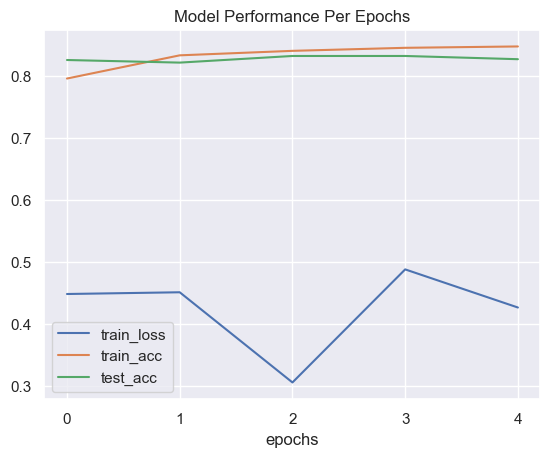

In [12]:


plot_performance(model_1_dictionary)

In [13]:
class Classification2(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.flatten_layer = nn.Flatten(1 , -1)
        self.Dense_1 = nn.Linear(in_features=input_shape, out_features=hidden_units)
        self.relu_1 = nn.ReLU()
        self.Dense_3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.Dense_2 = nn.Linear(in_features=hidden_units, out_features=output_shape)
        
    def forward(self,x):
        return self.Dense_2(self.relu_1(self.Dense_3(self.relu_1(self.Dense_1(self.flatten_layer(x))))))

def accuracy_fn(y_test, y_pred):
    count = torch.eq(y_test, y_pred).sum().item()
    return (count/len(y_pred)) * 100.00

In [14]:
model_2 = Classification2(input_shape=784, hidden_units=32, output_shape=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)
epochs = 5

model_2_dictionary = {'train_loss': [],
                            'train_acc':[],
                            'test_acc':[]}

train_model(model_2, epochs, optimizer, loss_fn, train_dataloader, test_dataloader, performance_dictionary=model_2_dictionary)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

1 / 5  Training Accuracy: 0.8 | Training loss: 0.56 | Testing Accuracy: 0.83


0it [00:00, ?it/s]

2 / 5  Training Accuracy: 0.84 | Training loss: 0.45 | Testing Accuracy: 0.84


0it [00:00, ?it/s]

3 / 5  Training Accuracy: 0.85 | Training loss: 0.28 | Testing Accuracy: 0.84


0it [00:00, ?it/s]

4 / 5  Training Accuracy: 0.85 | Training loss: 0.51 | Testing Accuracy: 0.85


0it [00:00, ?it/s]

5 / 5  Training Accuracy: 0.86 | Training loss: 0.19 | Testing Accuracy: 0.85


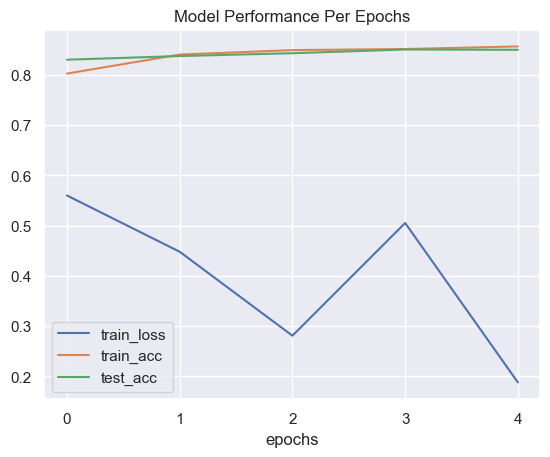

In [15]:
plot_performance(model_2_dictionary)

In [16]:
class Classification3(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential( 
            nn.Conv2d(in_channels=input_shape,out_channels = hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,
                        kernel_size=3,stride = 1,padding = 1),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.conv_block_2 = nn.Sequential( 
            nn.Conv2d(in_channels=hidden_units,out_channels = hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,
                        kernel_size=1,stride = 1,padding = 1),
            nn.MaxPool2d(kernel_size=2)
            )
        self.flatten_layer = nn.Flatten(1 , -1)
        self.Dense_2 = nn.Linear(in_features=hidden_units * 8 * 8, out_features=output_shape)
        
    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.flatten_layer(x)
        x = self.Dense_2(x)
        return x

def accuracy_fn(y_test, y_pred):
    count = torch.eq(y_test, y_pred).sum().item()
    return (count/len(y_pred)) * 100.00


In [17]:
model_3_dictionary = {'train_loss': [],
                            'train_acc':[],
                            'test_acc':[]}
model_3 = Classification3(input_shape=1, hidden_units=32, output_shape=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01)
epochs = 5
print(model_3)

train_model(model_3, epochs, optimizer,  loss_fn, train_dataloader, test_dataloader, performance_dictionary=model_3_dictionary )

Classification3(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (Dense_2): Linear(in_features=2048, out_features=10, bias=True)
)


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

1 / 5  Training Accuracy: 0.86 | Training loss: 0.52 | Testing Accuracy: 0.88


0it [00:00, ?it/s]

2 / 5  Training Accuracy: 0.9 | Training loss: 0.22 | Testing Accuracy: 0.89


0it [00:00, ?it/s]

3 / 5  Training Accuracy: 0.9 | Training loss: 0.2 | Testing Accuracy: 0.89


0it [00:00, ?it/s]

4 / 5  Training Accuracy: 0.9 | Training loss: 0.34 | Testing Accuracy: 0.87


0it [00:00, ?it/s]

5 / 5  Training Accuracy: 0.91 | Training loss: 0.56 | Testing Accuracy: 0.91


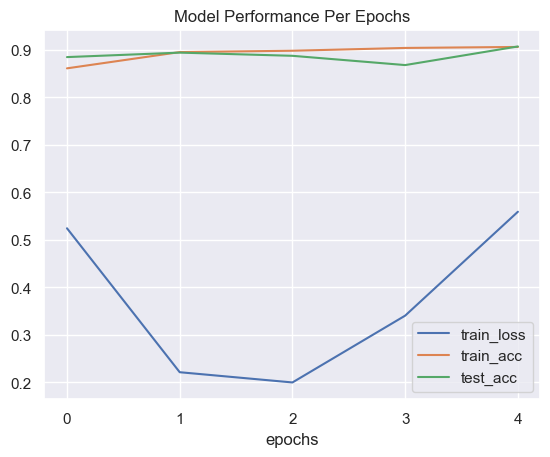

In [18]:
plot_performance(model_3_dictionary)

In [19]:
y_pred, y = predict(model_3, test_dataloader)



In [20]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns

cm = confusion_matrix(y_pred, y)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'T-shirt/top'),
  Text(0, 1.5, 'Trouser'),
  Text(0, 2.5, 'Pullover'),
  Text(0, 3.5, 'Dress'),
  Text(0, 4.5, 'Coat'),
  Text(0, 5.5, 'Sandal'),
  Text(0, 6.5, 'Shirt'),
  Text(0, 7.5, 'Sneaker'),
  Text(0, 8.5, 'Bag'),
  Text(0, 9.5, 'Ankle boot')])

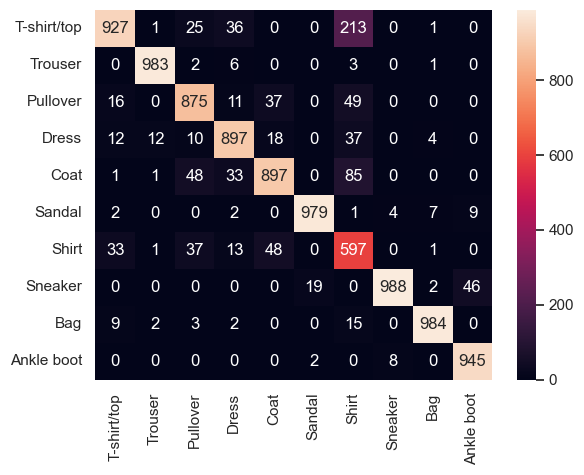

In [21]:
g = sns.heatmap(cm, annot=True, fmt='g')
g.set_xticklabels(train_data.classes, ha='center')
g.set_yticklabels(train_data.classes, va='center')
plt.xticks(rotation=90)
plt.yticks(rotation=0)